# Reference : https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ko

# 라이브러리 import

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# 그래프 시각화 함수 정의

In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

# IMDB Movie Review Dataset 다운로드 및 Sanity Check

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteH21N5A/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteH21N5A/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteH21N5A/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Vocabulary size: 8185


In [4]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [5]:
assert original_string == sample_string

for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [8]:
for x, y in train_dataset.take(1):
  print(x)
  print(y)

tf.Tensor(
[[2016   14    9 ...    0    0    0]
 [ 977   39 7968 ...    0    0    0]
 [  12  284   14 ...    0    0    0]
 ...
 [1419  281  527 ...    0    0    0]
 [5702 7961 4606 ...    0    0    0]
 [  12 4628   36 ...    0    0    0]], shape=(64, 1274), dtype=int64)
tf.Tensor(
[0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1], shape=(64,), dtype=int64)


# Sentiment Classification을 위한 Bidirectional RNN 구성

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [10]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 118s 278ms/step - loss: 0.6742 - accuracy: 0.5293 - val_loss: 0.5455 - val_accuracy: 0.7396
Epoch 2/10
391/391 [==============================] - 80s 204ms/step - loss: 0.3781 - accuracy: 0.8410 - val_loss: 0.3520 - val_accuracy: 0.8557
Epoch 3/10
391/391 [==============================] - 63s 159ms/step - loss: 0.2694 - accuracy: 0.8970 - val_loss: 0.3248 - val_accuracy: 0.8656
Epoch 4/10
391/391 [==============================] - 51s 131ms/step - loss: 0.2213 - accuracy: 0.9178 - val_loss: 0.3647 - val_accuracy: 0.8755
Epoch 5/10
391/391 [==============================] - 46s 117ms/step - loss: 0.1912 - accuracy: 0.9319 - val_loss: 0.3355 - val_accuracy: 0.8635
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.1723 - accuracy: 0.9408 - val_loss: 0.3373 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 42s 107ms/step - loss: 0.1593 - accuracy: 0.9464 - val_loss: 0.3716 - val_a

In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 14s 36ms/step - loss: 0.4435 - accuracy: 0.8461
Test Loss: 0.44350340962409973
Test Accuracy: 0.8460800051689148


# 예측값이 > 0.5보다 크면 긍정리뷰, < 0.5면 부정리뷰로 판단합니다.

In [12]:
def sample_predict(sample_pred_text):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [13]:
# predict on a sample text
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text)
print(predictions)

1/1 [==============================] - 1s 659ms/step
[[-0.20745857]]


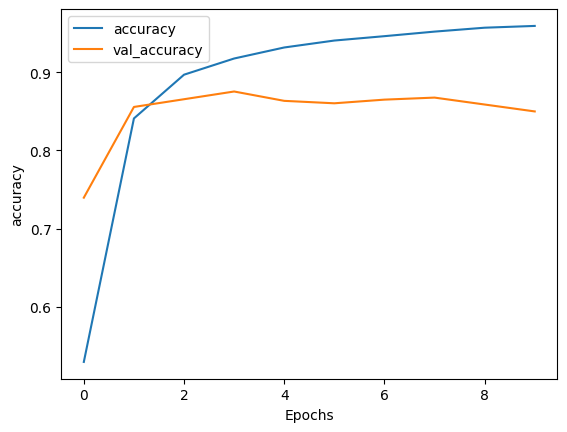

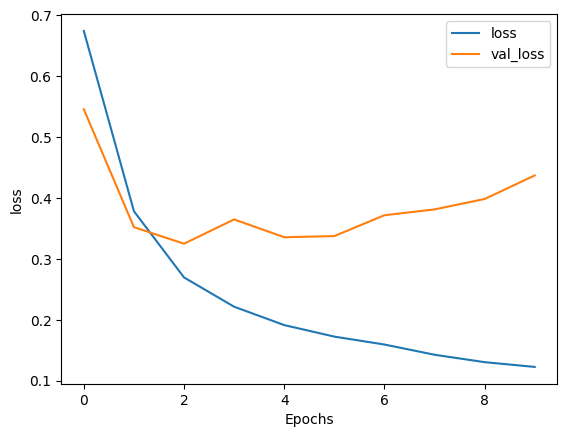

In [14]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [15]:
# Stack two or more LSTM layers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 116s 276ms/step - loss: 0.6672 - accuracy: 0.5422 - val_loss: 0.5048 - val_accuracy: 0.7573
Epoch 2/10
391/391 [==============================] - 90s 229ms/step - loss: 0.3942 - accuracy: 0.8327 - val_loss: 0.3841 - val_accuracy: 0.8521
Epoch 3/10
391/391 [==============================] - 79s 201ms/step - loss: 0.2733 - accuracy: 0.8994 - val_loss: 0.3367 - val_accuracy: 0.8641
Epoch 4/10
391/391 [==============================] - 74s 189ms/step - loss: 0.2198 - accuracy: 0.9260 - val_loss: 0.3490 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 71s 181ms/step - loss: 0.1883 - accuracy: 0.9390 - val_loss: 0.3892 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 66s 168ms/step - loss: 0.1650 - accuracy: 0.9500 - val_loss: 0.3998 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 64s 164ms/step - loss: 0.1427 - accuracy: 0.9585 - val_loss: 0.4361 - val_a

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 24s 61ms/step - loss: 0.5450 - accuracy: 0.8489
Test Loss: 0.5449798703193665
Test Accuracy: 0.8488799929618835


In [18]:
# predict on a sample text
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text)
print(predictions)

1/1 [==============================] - 1s 1s/step
[[-2.1357605]]


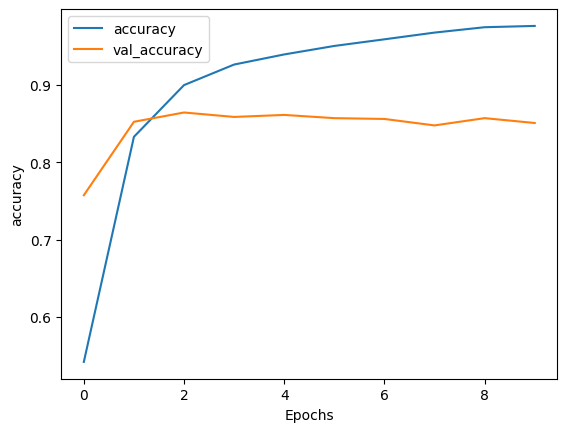

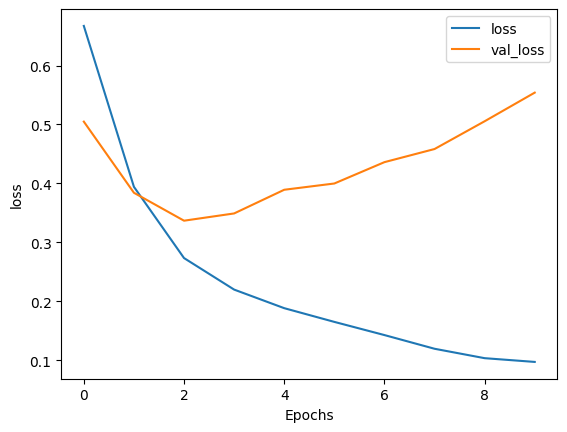

In [19]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')